# Model for common spatial pattern (CSP) feature calculation and classification for EEG data

> Adapted from https://github.com/MultiScale-BCI/IV-2a



In [2]:
# !pip install lightgbm scikit-plot xgboost catboost mlxtend eclf xgboost

import time

import numpy as np
import pandas as pd 
from sklearn.decomposition import * 
from sklearn.preprocessing import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import *

import xgboost  # xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier
import lightgbm # lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
import catboost # catboost.ai/docs/concepts/python-quickstart.html
import scikitplot as skplt
from mlxtend.classifier import EnsembleVoteClassifier

# import self defined functions
from csp import generate_projection, generate_eye, extract_feature
from filters import load_filterbank
from get_data import get_data

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical


# import matplotlib.pyplot as plt
# %matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Init

In [3]:
crossvalidation = False

data_path = 'data_2a_mat/'
svm_kernel = 'linear'  # 'sigmoid'#'linear' # 'sigmoid', 'rbf', 'poly'
svm_c = 0.1  # 0.05 for linear, 20 for rbf, poly: 0.1
useCSP = True
NO_splits = 5  # number of folds in cross validation
fs = 250.  # sampling frequency
NO_channels = 22  # number of EEG channels
NO_subjects = 9
NO_csp = 24  # Total number of CSP feature per band and timewindow
bw = np.array([2, 4, 8, 16, 32])  # bandwidth of filtered signals
ftype = 'butter'  # 'fir', 'butter'
forder = 2  # 4
filter_bank = load_filterbank(bw, fs, order=forder, max_freq=40,
                                   ftype=ftype)  # get filterbank coeffs
time_windows_flt = np.array([
    [2.5, 3.5],
    [3, 4],
    [3.5, 4.5],
    [4, 5],
    [4.5, 5.5],
    [5, 6],
    [2.5, 4.5],
    [3, 5],
    [3.5, 5.5],
    [4, 6],
    [2.5, 6]]) * fs  # time windows in [s] x fs for using as a feature

time_windows = time_windows_flt.astype(int)
# restrict time windows and frequency bands
# time_windows = time_windows[10] # use only largest timewindow
# filter_bank = filter_bank[18:27] # use only 4Hz bands

NO_bands = filter_bank.shape[0]
NO_time_windows = int(time_windows.size / 2)
NO_features = NO_csp * NO_bands * NO_time_windows
global train_time
train_time = 0
train_trials = 0
global eval_time
eval_time = 0
eval_trials = 0

In [4]:
# 1. Get data
subject = 1 # [1..10]
train_data, train_label = get_data(subject, True, data_path)
eval_data, eval_label = get_data(subject, False, data_path)

# 2. Apply CSP to bands to get spatial filter
if useCSP:
    w = generate_projection(train_data, train_label, NO_csp, filter_bank, time_windows)
else:
    w = generate_eye(train_data, train_label, filter_bank, time_windows)

# 3. Extract features for training and testing
feature_mat = extract_feature(train_data, w, filter_bank, time_windows)
eval_feature_mat = extract_feature(eval_data, w, filter_bank, time_windows)

In [5]:
start_train = time.time()

# 4. Train Model(s)
clf = LinearSVC(C=svm_c, loss='hinge', random_state=1, tol=0.00001)   # 0.87
# clf = SVC(svm_c, svm_kernel, degree=10, gamma='auto', coef0=0.0, tol=0.001, cache_size=10000, max_iter=-1, decision_function_shape='ovr')  # 0.85

clf.fit(feature_mat, train_label)
success_rate = clf.score(eval_feature_mat, eval_label)
print(f'Acc: {success_rate:.5f} Time taken: { time.time() - start_train:.3f}')

LinearSVC(C=0.1, loss='hinge', random_state=1, tol=1e-05)

Acc: 0.86833 Time taken: 8.636


In [6]:
X_train = feature_mat.copy()
X_test = eval_feature_mat.copy()

print(f'Data is of shape {X_train.shape}')
wanted_explained_variance_ratio = 0.95
wanted_n_components = min(X_train.shape)
steps_down =  5 # wanted_n_components // 80

first_time = True

for i in range(wanted_n_components-1, 1, -steps_down):
  total_var_ratio = round(np.sum(PCA(n_components=i).fit(X_train).explained_variance_ratio_), 5)
  print('i =', i, 'with a variance ratio of', total_var_ratio)
  if total_var_ratio < wanted_explained_variance_ratio and first_time:
    wanted_n_components = i + steps_down
    first_time = False
    break

print("We should set n_components to: ", wanted_n_components)
print(f'If we use PCA(n={wanted_n_components}), we can be left with only {100 * wanted_n_components/X_train.shape[1]:.2f}% of the original data')


pca = PCA(n_components=wanted_n_components, copy=False)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
y_train = train_label
y_test = eval_label
print(f'Data is now of shape :{X_train.shape})')

Data is now of shape :(273, 11352))


In [6]:
# Subject #1, PCA(n=222), 0.87900 for the EnsembleVoteClassifier
# Subject #1, PCA(n=222), 0.74733 for the EnsembleVoteClassifier

X_train = feature_mat
X_test = eval_feature_mat

SVM = SVC(C=1, cache_size=1000, probability=True, tol=0.00001) # DecisionTreeClassifier() # 0.85 with default C. 
RFC = RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1)
ETC = ExtraTreesClassifier(n_estimators=350, random_state=42, n_jobs=-1)
# XGB = xgboost.XGBClassifier(n_estimators=150, n_jobs=-1)
GBM = lightgbm.LGBMClassifier(n_estimators=500, objective='multiclass')

list_of_CLFs_names = []
list_of_CLFs = [SVM, RFC, ETC, GBM] # XGB
ranking = []

for clf in list_of_CLFs:
    _ = clf.fit(X_train,y_train)
    pred = clf.score(X_test,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)

best = max(ranking)
avg = sum(ranking)/len(ranking)
variance = avg - best
to_remove = ranking - avg - variance
to_remove_alt = ranking - best - variance
print(list_of_CLFs_names)
print('Negatives will be removed: \n', [round(elm,2) for elm in to_remove])
# print(to_remove_alt)
ranking = (np.array(ranking)[to_remove > 0]).tolist()
list_of_CLFs = (np.array(list_of_CLFs)[to_remove > 0]).tolist()

eclf = EnsembleVoteClassifier(clfs=list_of_CLFs, fit_base_estimators=False, voting='soft')
_ = eclf.fit(X_train, y_train)
pred = eclf.score(X_test, y_test)
print("Acc: %0.5f for the %s" % (pred, str(type(eclf)).split(".")[-1][:-2]))

Acc: 0.85053 for the SVC
Acc: 0.87900 for the RandomForestClassifier
Acc: 0.85765 for the ExtraTreesClassifier
Acc: 0.87544 for the LGBMClassifier
['SVC', 'RandomForestClassifier', 'ExtraTreesClassifier', 'LGBMClassifier']
Negatives will be removed: 
 [-0.0, 0.03, 0.01, 0.02]
Acc: 0.87900 for the EnsembleVoteClassifier


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

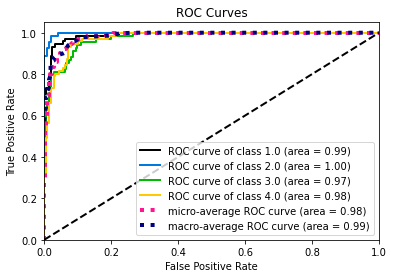

In [7]:
pred = eclf.predict(X_test)
probas = eclf.predict_proba(X_test)
skplt.metrics.plot_roc(y_true=y_test, y_probas=probas)


In [8]:
feature_mat.shape
eval_feature_mat.shape


(273, 11352)

(281, 11352)

In [20]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import OneHotEncoder

seq_length = 0

X_train = feature_mat
X_test = eval_feature_mat
y_train = train_label[seq_length:]
y_test = eval_label[seq_length:]

y_train = y_train-1
y_test = y_test-1

# enc = OneHotEncoder(handle_unknown='ignore')
# y_train_oneHot, y_test_oneHot = enc.fit_transform(y_train.reshape(-1, 1)), enc.transform(y_test.reshape(-1, 1))
y_train_oneHot, y_test_oneHot = to_categorical(y_train), to_categorical(y_test)

# seqLen=60
# seq_train=sequence.pad_sequences(sequences=X_train, maxlen=seqLen, padding='post', dtype='float32', truncating='post')
# seq_test=sequence.pad_sequences(sequences=X_test, maxlen=seqLen, padding='post', dtype='float32', truncating='post')




# def build_dataset(time_series, seq_length = seq_length):
#     dataX = []
#     for i in range(0, len(time_series) - seq_length):
#         _x = time_series[i:i + seq_length]
# #         print(_x, "->", _y)
#         dataX.append(_x)
#     return np.array(dataX)

# x_train = build_dataset(X_train)
# x_test = build_dataset(X_test)

x_train = X_train
x_test = X_test

x_train.shape
x_test.shape

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test  = np.reshape(x_test,  (x_test.shape[0], x_test.shape[1], 1))

x_train.shape
y_train.shape

x_test.shape
y_test.shape

(273, 11352)

(281, 11352)

(273, 11352, 1)

(273,)

(281, 11352, 1)

(281,)

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [21]:
## X_train = X_train.T
## X_test = X_test.T

# seq_train, seq_test = [], []
# seqLen = 60
# for i in range(seqLen, X_train.shape[0]):
#     seq_train.append(X_train[i-seqLen:i,0])

# for z in range(seqLen, X_test.shape[0]):
#     seq_test.append(X_test[z-seqLen:z,0])

# seq_train, seq_test = np.array(seq_train), np.array(seq_test)

# seq_train=np.reshape(seq_train, (seq_train.shape[0], seq_train.shape[1],1))
# seq_test=np.reshape(seq_test, (seq_test.shape[0], seq_test.shape[1],1))


x_train.shape

(273, 11352, 1)

In [31]:
model = Sequential()
model.add(LSTM(64, stateful=False, return_sequences=False)) # ,return_sequences=True is need for deep ("stacked") # stateful=False
model.add(BatchNormalization())
# model.add(LSTM(150, stateful=True, return_sequences=True)) # ,return_sequences=True is need for deep ("stacked")
# model.add(LSTM(75,  stateful=True, return_sequences=False)) # ,return_sequences=True is need for deep ("stacked")
# model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))

model.add(Dense(4, activation='softmax'))

opt = tf.optimizers.RMSprop(0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) # , metrics=['accuracy']  # sparse_ # categorical_accuracy

#  input_shape=(y_train.shape[0], y_train.shape[1], None)
# model.summary()

In [47]:
# history = model.fit(x_train, y_train_oneHot, epochs=10, batch_size=18, validation_data=(x_test, y_test_oneHot)).history #

history = model.fit(x_train, y_train_oneHot, epochs=5, batch_size=64) # , validation_data=(x_test, y_test)).history #

Epoch 1/15


KeyboardInterrupt: 

In [29]:
# pred = model.evaluate(x_train, y_train)
# pred

# pred = model.predict(x_test, y_test_oneHot)
pred = model.predict(x_train, y_train_oneHot)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

NameError: name 'a' is not defined

In [46]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


^C
